train.csv shape is  (139753, 9)
test.csv shape is  (13976, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0  1049849  B000MR9D5E  A1EKSETIBS9ETQ                     0   
1   999834  B000GAKFIG   AR0HFYHYHDGQQ                     2   
2   218826  6300215776  A37S3ACL57LN62                    11   
3   796384  B00019071C  A1TO1P3NV7OAU6                     2   
4  1219784  B001NFNFN0   ATCM1W7HWIC6U                     0   

   HelpfulnessDenominator        Time  \
0                       0  1198281600   
1                       5  1245024000   
2                      15  1126137600   
3                       2  1351036800   
4                       0  1381708800   

                                             Summary  \
0  Great nature series, but not all scenes looked...   
1                 Agatha Christie's Marple: Series 2   
2                             Childish Entertainment   
3                       The weakest Babylon 5 season   
4                        

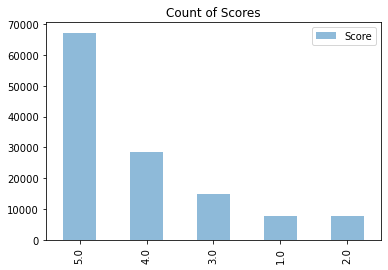

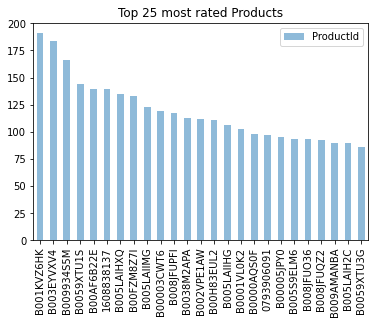

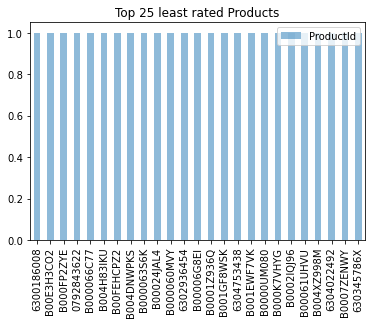

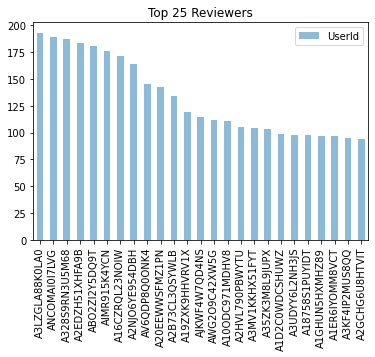

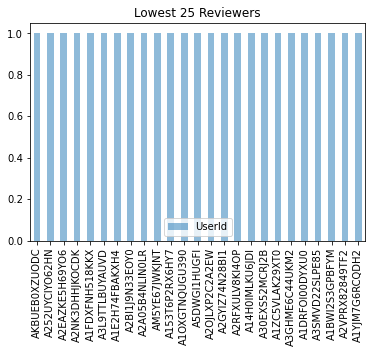

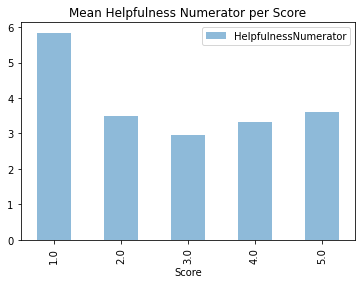

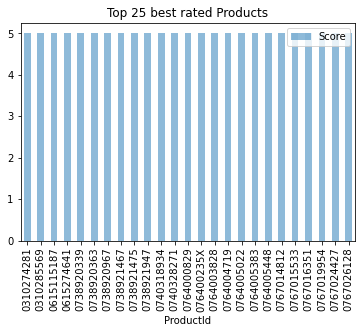

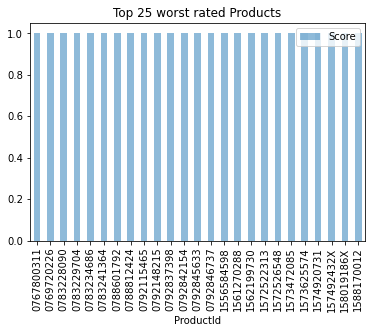

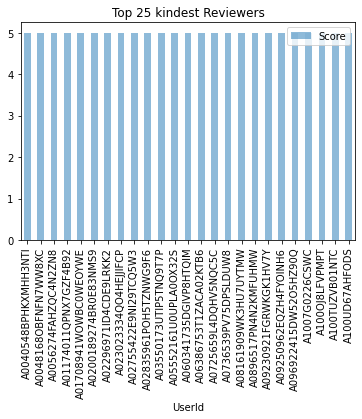

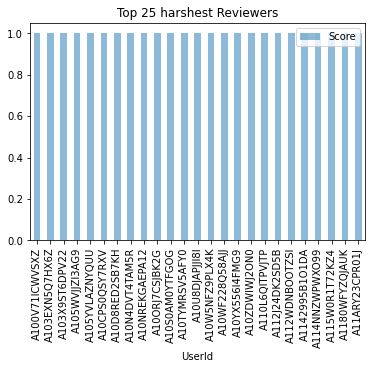

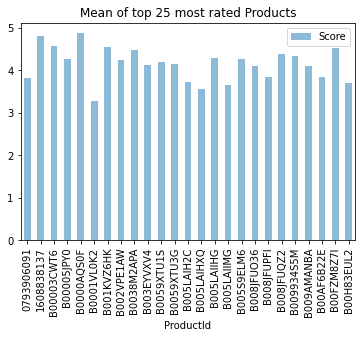

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import pandas as pd
import matplotlib.pyplot as plt


trainingSet = pd.read_csv("/Users/steviewong/Desktop/midterm_506/train.csv")
testingSet = pd.read_csv("/Users/steviewong/Desktop/midterm_506/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 most rated Products")
plt.show()

trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 least rated Products")
plt.show()

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers")
plt.show()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers")
plt.show()

trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 best rated Products")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 worst rated Products")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 kindest Reviewers")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 harshest Reviewers")
plt.show()

trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean of top 25 most rated Products")
plt.show()

## Feature Extraction

In [35]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
pd.set_option("max_rows", 600)
from pathlib import Path  
import glob
import numpy as np
from nltk.tokenize import  word_tokenize 
def process(df):
    # This is where you can do all your processing

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
    
    #df['SummaryLength'] = df.apply(lambda row : len(row['Summary'].split()) if type(row['Summary']) == str else 0, axis = 1)
    
    bad_words = ['superficial','Superficial','terrible','Terrible','obnoxious','Obnoxious','disappointing','Disappointing', 'unprepared','Unprepared', 'problem','Problem', 'boring','Boring', 'propaganda','Propaganda',  'plot holes','Plot holes',  'inaccurate' ,'Inaccurate', 'lame','Lame', 'crap','Crap', 'disinterested','Disinterested','uninteresting',  'long','Long' 'lack','Lack', 'lacked','weak','Weak','not good','Lacked', 'lacking','Lacking',  'desperate','Desperate', 'shameless', 'Shameless','bad','Bad','mindless','Mindless','tolerable','Tolerable']

    # define the list of words to search for
    good_words = ['interesting','Interesting', 'classic','Classic', 'best','Best', 'enjoy','Enjoy', 'excellent','Excellent','perfect','Perfect', 'like','Like', 'hilarious','Hilarious', 'goodie','Goodie', 'favorite','Favorite', 'good','Good', 'love','Love','lover','Lover', 'cry','Cry', 'clever','Clever', 'subtle','Subtle', 'superior','Superior',  'enjoyable','Enjoyable', 'quirky','Quirky', 'entertaining','Entertaining', 'fan','Fan',  'great','Great', 'solid','Solid',  'stunning','Stunning', 'fantastic' ,'Fantastic', 'relate','Relate', 'funny','Funny','fun','Fun', 'cool','Cool', 'likable','Likable']#, 'can’t stop watching'

    # create a boolean mask indicating whether any word from the list 'x' is present in each row of the 'col1' column
    x = 0
    #df['num_good'] = df.apply(lambda row: len[])
    
#     mask = df['Text'].str.contains('|'.join(good_words))
    
#     print(df['mask'])

    negation = ['not','Not','too little', 'Too little',"couldn't", "Couldn't","can't","Can't","isn't","Isn't", "hardly","Hardly","barely","Barely","never","Never"]
    
    pattern = '|'.join(good_words)
    pattern1 = '|'.join(bad_words)
    pattern2 = '|'.join(negation)
    # check if any cell in the 'text' column contains any of the words in the list
    df['contains_gword'] = df['Text'].str.contains(pattern)
    df['contains_bword'] = df['Text'].str.contains(pattern1)
    df['contains_negations'] = df['Text'].str.contains(pattern2)
    
    df['goodandbad'] = df.apply(lambda row: 1 if row['contains_gword'] == 1 else 0, axis =1)
    
    
    
    
    
    
    
    df["negation_count"] = df['Text'].str.count('|'.join(negation))
    df['negation_count'] = df['negation_count'].fillna(0)
    df["good_count"] = df['Text'].str.count('|'.join(good_words)) 
    df["good_count"] = df['good_count'].fillna(0)
    
    df["bad_count"] = df['Text'].str.count('|'.join(bad_words))
    df["bad_count"] = df['bad_count'].fillna(0)
#     #df['A'].div(100).round(2)
    
    df['good_ratio'] = df['good_count'].div(df['ReviewLength']).round(3)
    df['good_ratio'] = df['good_ratio'].fillna(0)
    df['bad_ratio'] = df['bad_count'].div(df['ReviewLength']).round(3)
    df['bad_ratio'] = df['bad_ratio'].fillna(0)
    df['negation_ratio'] = df['negation_count'].div(df['ReviewLength']).round(3)
    df['negation_ratio'] = df['negation_ratio'].fillna(0)
    
    df['ratio_per'] = df['good_ratio'] - df['bad_ratio']# - df['negation_ratio']
    df['ratio_per'] = df['ratio_per'].fillna(0)
    df['ratio'] = df['good_count']- df['bad_count'] -df['negation_count'] #- df['negation_count']
    df['ratio'] = df['ratio'].fillna(0)
    
    df['Score'] = df.apply(lambda row: 5.0 if row['Score'] == None and row['ratio'] > 0 and row['Helpfulness']==0 else 5.0 if row['Score'] == None and row['ratio'] >= 0 and row['ReviewLength'] > 400 else 1.0 if row['Score'] == None and row['ratio']< 0 and row['contains_gword']== True  else 3.0 if row['Score'] == None and row['ratio'] == 0 else row['Score'], axis=1)
    
    df['length_type'] = df.apply(lambda row: 1 if row['ReviewLength'] <= 100 else 2 if row['ReviewLength'] > 100 and row['ReviewLength'] <=300 else 3,axis =1)
    df['length_type'] = df['length_type'].fillna(3)
    #duplicates = df.duplicated(subset=['col2'])
    df['same_user'] = df.duplicated(subset = ['UserId'])
    
    
    #df['goodbad_user'] = df.apply(lambda row: 1 if row['same_user'] == True and row['Score'] >4 else 0 if row['same_user'] == 'True' and row['Score']<= 2 else .5  , axis =1)
    df['returning_user'] = df.apply(lambda row: 1 if row['same_user']== True else 0, axis =1)
    
    df['same_movie'] = df.duplicated(subset = ['ProductId'])
    df['movie_repeated']  = df.apply(lambda row: 1 if row['same_movie'] == True else 0, axis = 1)
    
    
    
    #df['goodbad_movie'] = df.apply(lambda row: 1 if row['same_movie'] == True and row['Score'] >=4 else 0 if row['same_movie'] == 'True' and row['Score']<= 3 else .5, axis =1)
    
    # how to get the average rating from all the users 
    
    
    
#     df['rated_before'] = df.groupby('UserId')['Score'].mean()
#     df['rated_before'] = df['rated_before'].fillna(0)
    
    
    
    #print(df['rated_before'])
    
    #notes
    ### get the number of good words y el number of bad words y despsdividir cada uno entre la cantidad de palabras
    # desps restar uno menos el otro, si es negativo es mas probable malo, si es 0 pon 3 
#   
# if it has a lot of ratings it is 3 or above most probably as more people are going to watch something that is good
# there are more positive reviews 


    
#Plots for analysis
#     Avgmean = df.groupby('Score')['ReviewLength'].mean()
    
#     Avgmean.plot.bar()
    
    
#     Avghelp = df.groupby('Score')['ratio'].mean()
    
#     Avghelp.plot.bar()
    
#     repeated = df.groupby('returning_user')['Score'].mean()
    
#     repeated.plot.bar()

#     movie = df.groupby('movie_repeated')['ReviewLength'].mean()
#     movie.plot.bar()

    
    
#     df['Text'] = df['Text'].fillna('')
    
    # TID_IDF implementation
#     tfidf = TfidfVectorizer()
#     tfi = CountVectorizer()
#     #tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
#     tfidf.fit(df['Text'])
#     tfi.fit(df['Text'])
#     #print(tfidf_matrix)
#     vocab = tfi.get_feature_names_out()
#     idf = tfidf.idf_

# # Transform the paragraph into a sparse matrix of TF-IDF scores
#     tfidf_matrix = tfidf.transform(df['Text'])

# # Convert the sparse matrix into a numpy array
#     tfidf_array = tfidf_matrix.toarray()
#     Dict = {}
# # Print the TF-IDF scores for each word
#     for i, score in enumerate(tfidf_array[0]):
#         Dict[vocab[i]]= score *idf[i]
#         #print(vocab[i], score * idf[i])
    
    
    
#     TF = add_dict_sum_column(df,'Text', Dict)
    
    #df['TF-IDF'] = df.apply(lambda row: )
    
    
    
        
    
    return df



def add_dict_sum_column(df, text_column, dict_to_sum):
    # Create a new column in the DataFrame to hold the sum of the dictionary values
    df['dict_sum'] = 0

    # Loop over the rows in the DataFrame
    for index, row in df.iterrows():
        # Split the text column into words
        words = row[text_column].split()

        # Sum the values from the dictionary for each word in the text column
        total_sum = 0
        for word in words:
            if word in dict_to_sum:
                total_sum += dict_to_sum[word]

        # Set the value of the 'dict_sum' column for this row to the total sum
        df.loc[index, 'dict_sum'] = total_sum

    return df

# Load the dataset
trainingSet = pd.read_csv("/Users/steviewong/Desktop/midterm_506/train.csv")





# create a sample dataframe




train_processed = process(trainingSet)



# Load test set
submissionSet = pd.read_csv("/Users/steviewong/Desktop/midterm_506/test.csv")
#testX = testX.drop(columns=['Score_x'])

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.rename(columns={'Score_y': 'Score'})
testX = testX.drop(columns=['Score_x'])
#testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]



#print(trainX.head())

# empty from row 125,779







#Save the datasets with the new features for easy access later
testX.to_csv("/Users/steviewong/Desktop/midterm_506/test1.csv", index=False)
trainX.to_csv("/Users/steviewong/Desktop/midterm_506/train1.csv", index=False)
print('done')

done


## Creating your model

In [36]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression

# Load training set with new features into DataFrame
X_train = pd.read_csv("/Users/steviewong/Desktop/midterm_506/train1.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId','UserId','Text', 'Summary','contains_gword','contains_bword','contains_negations','good_ratio','bad_ratio','negation_ratio','Time','HelpfulnessDenominator','HelpfulnessNumerator','length_type','same_user','same_movie', 'ratio_per'])

X_test_processed = X_test.drop(columns=['Id', 'ProductId','UserId', 'Text', 'Summary','contains_gword','contains_bword','contains_negations','good_ratio','bad_ratio','negation_ratio','Time','HelpfulnessDenominator','HelpfulnessNumerator','length_type','same_user','same_movie', 'ratio_per'])



# Learn the model
model = KNeighborsClassifier(n_neighbors=20).fit(X_train_processed, Y_train)


# pickle model - saves it so you can load it later
# with open('/kaggle/working/knn_20_model.obj', 'wb') as f:
#         pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

#print(X_test_processed.head())
# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)


model1 = LinearRegression()

model1.fit(X_train_processed, Y_train)

Y_test_pred = model1.predict(X_test_processed)

print(Y_test_predictions)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

print(Y_test_pred)
# Plot a confusion matrix
# cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
# sns.heatmap(cm, annot=True)
# plt.title('Confusion matrix of the classifier')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# plt.scatter(X_train_processed, Y_train)
# plt.plot(X_train_processed, predictions, color='red')
# plt.xlabel('X')
# plt.ylabel('y')
# plt.title('Example Scatter Plot with Regression Line')
# plt.show()

/Users/steviewong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[5. 5. 5. ... 5. 3. 5.]
Accuracy on testing set =  0.5181427889966609
RMSE on testing set =  1.9539195420575608
[4.36156668 4.38878256 4.29368301 ... 4.46764535 3.43808897 3.71574636]


## Creating a kaggle submission

In [37]:
X_submission = pd.read_csv("/Users/steviewong/Desktop/midterm_506/test1.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score','contains_gword','contains_bword','contains_negations','good_ratio','bad_ratio','negation_ratio','Time','HelpfulnessDenominator','HelpfulnessNumerator','length_type','same_movie','same_user',  'ratio_per'])
X_submission['Score'] = model1.predict(X_submission_processed) 
#X_submission['Score'] = train_processed.apply(lambda row: 5.0 if row['Score'] == None and row['ratio'] > 0 and row['Helpfulness']==0 else 5.0 if row['Score'] == None and row['ratio'] >= 0 and row['ReviewLength'] > 400 else 1.0 if row['Score'] == None and row['ratio']< 0 and row['contains_gword']== True  else 3.0 if row['Score'] == None and row['ratio'] == 0 else row['Score'], axis=1)
print(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/Users/steviewong/Desktop/midterm_506/submission.csv", index=False)

       Helpfulness  ReviewLength  goodandbad  negation_count  good_count  \
0              0.0            47           0             0.0         0.0   
1              1.0           160           1             2.0         2.0   
2              1.0           999           1             5.0         5.0   
3              0.0            31           1             0.0         1.0   
4              0.5            30           1             0.0         3.0   
...            ...           ...         ...             ...         ...   
13971          0.0            27           1             0.0         1.0   
13972          1.0           129           1             0.0         5.0   
13973          0.0            44           1             0.0         3.0   
13974          1.0           126           1             0.0         6.0   
13975          0.0            59           1             1.0         2.0   

       bad_count  ratio  returning_user  movie_repeated  
0            0.0    0.0      